# Lightgbm

In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

import lightgbm

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler

from IPython.display import display

from utils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load data

In [3]:
train = pd.read_csv('input/train.csv')
print(train.shape)

(307511, 199)


In [5]:
#display(train.head(2))

In [4]:
test = pd.read_csv('input/test.csv')
print(test.shape)

(48744, 198)


### Load possible outliers (Optional)

In [3]:
outliers_idx = np.load('isolation_forest_outliers.npy', mmap_mode='r')
outliers_idx = np.array(outliers_idx)

Outliers removal (optional step)

In [ ]:
train = train.drop(index=train.index[outliers_idx])
train = train.reset_index(drop=True)

### Removing service and target columns

In [5]:
targets = train[['TARGET']]

train_ids = train['SK_ID_CURR']
train = train.drop(columns=['SK_ID_CURR', 'TARGET'])

In [6]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

In [7]:
targets.shape

(307511, 1)

### Drop redundant columns
Columns which almost identical (correlation is close to 1)

In [8]:
cols_drop = appartment_mode_cols + appartment_medi_cols
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)

In [9]:
print(train.shape)
print(test.shape)

(307511, 177)
(48744, 177)


### List Categorical Features

In [10]:
cat_features = train.select_dtypes('object').columns.tolist()

In [11]:
for col in cat_features: 
    train[col] = train[col].astype('category') 
    test[col] = test[col].astype('category') 

### Parameter Tuning

In [15]:
params = {
    'learning_rate': [0.05],
    'n_estimators': [10000],
    'num_leaves': [32, 64],
    'max_depth': [-1, 7],
    'min_child_samples': [80, 160],
    'reg_alpha': [2.0, 4.0],
    'reg_lambda': [1.0, 2.0],
    'max_bin': [255]
}

# rscv = RandomizedSearchCV(model, params, n_iter=20, cv=5, n_jobs=1, verbose=1)
# rscv.fit(train, targets[['TARGET']], categorical_feature=cat_features,
#          eval_metric='auc', verbose=100)
cv_results = []

for i, param_smple in enumerate(list(ParameterSampler(params, 10))):
    print('Iteration %i, params: %s' % (i, param_smple))
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []
    train_scores = []
    params_ = dict(param_smple)
    params_['params'] = param_smple
    start = time.time()
    fold_i = 0
    model = lightgbm.LGBMClassifier(n_estimators=param_smple['n_estimators'], objective='binary', 
                                    class_weight='balanced', learning_rate=param_smple['learning_rate'], 
                                    num_leaves=param_smple['num_leaves'], max_depth=param_smple['max_depth'],
                                    reg_alpha=param_smple['reg_alpha'], reg_lambda=param_smple['reg_lambda'], 
                                    min_child_samples=param_smple['min_child_samples'],
                                    subsample=0.8, n_jobs=6, random_state=4242, max_bin=param_smple['max_bin'])
    
    for train_indices, valid_indices in k_fold.split(train, targets):
        train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
        valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    
        model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                      eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                      eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        params_['train_score_%s' % fold_i] = model.best_score_['train']['auc']
        params_['valid_score_%s' % fold_i] = model.best_score_['valid']['auc']
        fold_i += 1
    
    end = time.time()
    params_['fit_time'] = end - start
    params_['mean_train_score'] = np.mean(train_scores)
    params_['mean_valid_score'] = np.mean(valid_scores)
    cv_results.append(params_)
    

Iteration 0, params: {'max_depth': 7, 'learning_rate': 0.05, 'num_leaves': 32, 'reg_lambda': 2.0, 'n_estimators': 10000, 'max_bin': 255, 'reg_alpha': 4.0, 'min_child_samples': 80}
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799395	valid's auc: 0.765144
[200]	train's auc: 0.825386	valid's auc: 0.772813
[300]	train's auc: 0.844485	valid's auc: 0.774921
[400]	train's auc: 0.860025	valid's auc: 0.775358
[500]	train's auc: 0.873535	valid's auc: 0.775464
[600]	train's auc: 0.885917	valid's auc: 0.775596
Early stopping, best iteration is:
[555]	train's auc: 0.880612	valid's auc: 0.77574
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.798488	valid's auc: 0.767914
[200]	train's auc: 0.824301	valid's auc: 0.774598
[300]	train's auc: 0.843218	valid's auc: 0.776464
[400]	train's auc: 0.859115	valid's auc: 0.776663
Early stopping, best iteration is:
[376]	train's auc: 0.855431	valid's auc: 0.776956
Training until validation

[100]	train's auc: 0.828543	valid's auc: 0.77064
[200]	train's auc: 0.86904	valid's auc: 0.776138
[300]	train's auc: 0.897393	valid's auc: 0.776528
Early stopping, best iteration is:
[292]	train's auc: 0.895344	valid's auc: 0.776776
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828881	valid's auc: 0.771527
[200]	train's auc: 0.869424	valid's auc: 0.776055
[300]	train's auc: 0.897456	valid's auc: 0.775831
Early stopping, best iteration is:
[211]	train's auc: 0.873181	valid's auc: 0.77617
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828623	valid's auc: 0.769925
[200]	train's auc: 0.869602	valid's auc: 0.774022
[300]	train's auc: 0.897497	valid's auc: 0.77358
Early stopping, best iteration is:
[223]	train's auc: 0.876793	valid's auc: 0.774418
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828713	valid's auc: 0.771929
[200]	train's auc: 0.869343	valid's auc: 0.776336
[300]	trai

[300]	train's auc: 0.847184	valid's auc: 0.777371
Early stopping, best iteration is:
[261]	train's auc: 0.83992	valid's auc: 0.777561
Iteration 9, params: {'max_depth': 7, 'learning_rate': 0.05, 'num_leaves': 32, 'reg_lambda': 1.0, 'n_estimators': 10000, 'max_bin': 255, 'reg_alpha': 4.0, 'min_child_samples': 80}
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799299	valid's auc: 0.765324
[200]	train's auc: 0.825003	valid's auc: 0.772993
[300]	train's auc: 0.843875	valid's auc: 0.775043
[400]	train's auc: 0.859915	valid's auc: 0.77536
[500]	train's auc: 0.873677	valid's auc: 0.774751
Early stopping, best iteration is:
[427]	train's auc: 0.864019	valid's auc: 0.775476
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799251	valid's auc: 0.768471
[200]	train's auc: 0.82481	valid's auc: 0.775481
[300]	train's auc: 0.843495	valid's auc: 0.776877
[400]	train's auc: 0.859298	valid's auc: 0.777335
[500]	train's auc: 0.873271

In [19]:
df_results = pd.DataFrame(cv_results)
df_results.sort_values('mean_valid_score', axis=0)

,fit_time,learning_rate,max_bin,max_depth,mean_train_score,mean_valid_score,min_child_samples,n_estimators,num_leaves,params,reg_alpha,reg_lambda,train_score_0,train_score_1,train_score_2,train_score_3,train_score_4,valid_score_0,valid_score_1,valid_score_2,valid_score_3,valid_score_4
2,209.345991,0.05,255,7,0.879643,0.774872,160,10000,64,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,1.0,0.884810,0.878929,0.870778,0.883375,0.880324,0.773982,0.775994,0.775934,0.773367,0.775080
4,221.092630,0.05,255,-1,0.884262,0.775698,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,1.0,0.891202,0.895344,0.873181,0.876793,0.884790,0.774554,0.776776,0.776170,0.774418,0.776569
7,230.559262,0.05,255,-1,0.886008,0.775903,160,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,1.0,0.885867,0.880709,0.900700,0.870250,0.892515,0.775475,0.776003,0.776658,0.774745,0.776636
5,219.593719,0.05,255,-1,0.881182,0.775955,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,1.0,0.892885,0.882636,0.872181,0.884327,0.873883,0.775252,0.776981,0.776253,0.774913,0.776378
3,243.125517,0.05,255,-1,0.888726,0.776094,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,2.0,0.903517,0.900325,0.869330,0.892090,0.878368,0.775331,0.776650,0.776021,0.774950,0.777520
6,227.609989,0.05,255,-1,0.862194,0.776147,160,10000,32,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,1.0,0.873431,0.859316,0.880181,0.851305,0.846737,0.775149,0.777162,0.777237,0.774826,0.776359
9,220.591223,0.05,255,7,0.853910,0.776186,80,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,1.0,0.864019,0.859661,0.842670,0.856077,0.847123,0.775476,0.777402,0.776402,0.774785,0.776862
8,205.577855,0.05,255,-1,0.850824,0.776347,160,10000,32,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,2.0,0.861142,0.847452,0.862335,0.843271,0.839920,0.776083,0.777526,0.776533,0.774035,0.777561
0,209.558289,0.05,255,7,0.855997,0.776403,80,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,2.0,0.880612,0.855431,0.845372,0.845025,0.853547,0.775740,0.776956,0.777227,0.774894,0.777196
1,226.068312,0.05,255,7,0.859351,0.776409,160,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",2.0,2.0,0.851097,0.873188,0.866143,0.843619,0.862705,0.775473,0.777569,0.776632,0.774995,0.777378


In [20]:
best_index = df_results.mean_valid_score.idxmax()
df_results.iloc[best_index]['params']

{'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 7,
 'min_child_samples': 160,
 'n_estimators': 10000,
 'num_leaves': 32,
 'reg_alpha': 2.0,
 'reg_lambda': 2.0}

In [21]:
df_results.iloc[best_index]

fit_time                                                       226.068
learning_rate                                                     0.05
max_bin                                                            255
max_depth                                                            7
mean_train_score                                              0.859351
mean_valid_score                                              0.776409
min_child_samples                                                  160
n_estimators                                                     10000
num_leaves                                                          32
params               {'max_depth': 7, 'learning_rate': 0.05, 'num_l...
reg_alpha                                                            2
reg_lambda                                                           2
train_score_0                                                 0.851097
train_score_1                                                 0.873188
train_

### Model K-Fold Execution

In [13]:
features = np.array(train)
test_features = np.array(test)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

valid_scores = []
train_scores = []
test_predictions = np.zeros(test_features.shape[0])

previous_params = {
    'learning_rate': 0.005,
    'n_estimators': 32000,
    'num_leaves': 32,
    'max_depth': 7,
    'min_child_samples': 160,
    'reg_alpha': 2.0,
    'reg_lambda': 2.0,
    'max_bin': 255
}

params = {
    'learning_rate': 0.01,
    'n_estimators': 32000,
    'num_leaves': 16,
    'max_depth': 5,
    'min_child_samples': 80,
    'reg_alpha': 2.0,
    'reg_lambda': 2.0,
    'max_bin': 127
}

model = lightgbm.LGBMClassifier(n_estimators=params['n_estimators'], objective='binary', 
                                class_weight='balanced', learning_rate=params['learning_rate'], 
                                num_leaves=params['num_leaves'], max_depth=params['max_depth'],
                                reg_alpha=params['reg_alpha'], reg_lambda=params['reg_lambda'],
                                min_child_sample=params['min_child_samples'],
                                subsample=0.8, n_jobs=6, random_state=4242, max_bin=params['max_bin'])

for train_indices, valid_indices in k_fold.split(features, targets):
    # Numpy version
    # Training data for the fold
    #train_features, train_labels = features[train_indices], targets[train_indices]
    # Validation data for the fold
    #valid_features, valid_labels = features[valid_indices], targets[valid_indices]
    
    # DataFrame version
    train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
    valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    test_features = test
    
    # d_train = lightgbm.Dataset(train_features, label=train_labels)
    # d_valid = lightgbm.Dataset(valid_features, label=valid_labels)
    # model = lightgbm.train(parameters, d_train, verbose_eval=100, valid_sets=[d_valid], num_boost_round=20000, early_stopping_rounds=200)
    
    # The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional
    # to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    
    model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

    best_iteration = model.best_iteration_
    
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.722354	valid's auc: 0.712049
[200]	train's auc: 0.727963	valid's auc: 0.71666
[300]	train's auc: 0.730623	valid's auc: 0.719338
[400]	train's auc: 0.732094	valid's auc: 0.720647
[500]	train's auc: 0.733373	valid's auc: 0.72178
[600]	train's auc: 0.734616	valid's auc: 0.722698
[700]	train's auc: 0.735969	valid's auc: 0.723698
[800]	train's auc: 0.737438	valid's auc: 0.724902
[900]	train's auc: 0.73913	valid's auc: 0.726486
[1000]	train's auc: 0.740816	valid's auc: 0.727948
[1100]	train's auc: 0.742681	valid's auc: 0.729414
[1200]	train's auc: 0.744488	valid's auc: 0.730727
[1300]	train's auc: 0.746316	valid's auc: 0.732029
[1400]	train's auc: 0.748475	valid's auc: 0.733504
[1500]	train's auc: 0.750441	valid's auc: 0.734797
[1600]	train's auc: 0.752336	valid's auc: 0.736159
[1700]	train's auc: 0.754022	valid's auc: 0.737388
[1800]	train's auc: 0.755767	valid's auc: 0.738698
[1900]	train's auc: 0.757594	va

[16100]	train's auc: 0.828223	valid's auc: 0.774053
[16200]	train's auc: 0.828486	valid's auc: 0.774092
[16300]	train's auc: 0.828753	valid's auc: 0.774122
[16400]	train's auc: 0.82902	valid's auc: 0.774153
[16500]	train's auc: 0.829292	valid's auc: 0.774175
[16600]	train's auc: 0.82955	valid's auc: 0.774214
[16700]	train's auc: 0.829812	valid's auc: 0.774247
[16800]	train's auc: 0.830072	valid's auc: 0.774285
[16900]	train's auc: 0.830326	valid's auc: 0.774317
[17000]	train's auc: 0.830579	valid's auc: 0.774357
[17100]	train's auc: 0.830831	valid's auc: 0.774392
[17200]	train's auc: 0.831079	valid's auc: 0.774428
[17300]	train's auc: 0.831328	valid's auc: 0.774465
[17400]	train's auc: 0.831575	valid's auc: 0.774491
[17500]	train's auc: 0.831816	valid's auc: 0.774513
[17600]	train's auc: 0.832064	valid's auc: 0.774544
[17700]	train's auc: 0.832314	valid's auc: 0.77457
[17800]	train's auc: 0.832561	valid's auc: 0.774594
[17900]	train's auc: 0.832805	valid's auc: 0.774614
[18000]	train's

[7800]	train's auc: 0.801894	valid's auc: 0.770671
[7900]	train's auc: 0.802292	valid's auc: 0.77081
[8000]	train's auc: 0.802678	valid's auc: 0.770939
[8100]	train's auc: 0.803061	valid's auc: 0.771055
[8200]	train's auc: 0.803443	valid's auc: 0.77117
[8300]	train's auc: 0.803819	valid's auc: 0.77128
[8400]	train's auc: 0.804184	valid's auc: 0.771389
[8500]	train's auc: 0.804555	valid's auc: 0.771478
[8600]	train's auc: 0.804913	valid's auc: 0.771567
[8700]	train's auc: 0.805261	valid's auc: 0.771658
[8800]	train's auc: 0.805617	valid's auc: 0.771738
[8900]	train's auc: 0.805963	valid's auc: 0.771811
[9000]	train's auc: 0.806309	valid's auc: 0.771886
[9100]	train's auc: 0.806655	valid's auc: 0.771967
[9200]	train's auc: 0.806997	valid's auc: 0.772054
[9300]	train's auc: 0.807345	valid's auc: 0.772135
[9400]	train's auc: 0.807683	valid's auc: 0.77222
[9500]	train's auc: 0.808017	valid's auc: 0.772285
[9600]	train's auc: 0.808344	valid's auc: 0.772361
[9700]	train's auc: 0.808673	valid'

[23700]	train's auc: 0.844776	valid's auc: 0.776706
[23800]	train's auc: 0.844991	valid's auc: 0.77671
[23900]	train's auc: 0.845201	valid's auc: 0.776713
[24000]	train's auc: 0.845414	valid's auc: 0.776715
Did not meet early stopping. Best iteration is:
[24000]	train's auc: 0.845414	valid's auc: 0.776715
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.724288	valid's auc: 0.717246
[200]	train's auc: 0.727116	valid's auc: 0.719735
[300]	train's auc: 0.730141	valid's auc: 0.722021
[400]	train's auc: 0.732013	valid's auc: 0.723691
[500]	train's auc: 0.733425	valid's auc: 0.725134
[600]	train's auc: 0.734906	valid's auc: 0.726258
[700]	train's auc: 0.736396	valid's auc: 0.727295
[800]	train's auc: 0.737838	valid's auc: 0.728572
[900]	train's auc: 0.739293	valid's auc: 0.729714
[1000]	train's auc: 0.740921	valid's auc: 0.731078
[1100]	train's auc: 0.74262	valid's auc: 0.732579
[1200]	train's auc: 0.744383	valid's auc: 0.733968
[1300]	train's auc: 0.746061

[15500]	train's auc: 0.824847	valid's auc: 0.776492
[15600]	train's auc: 0.825101	valid's auc: 0.776516
[15700]	train's auc: 0.825358	valid's auc: 0.776536
[15800]	train's auc: 0.825612	valid's auc: 0.776562
[15900]	train's auc: 0.825864	valid's auc: 0.776581
[16000]	train's auc: 0.826118	valid's auc: 0.776606
[16100]	train's auc: 0.826378	valid's auc: 0.776634
[16200]	train's auc: 0.826625	valid's auc: 0.776661
[16300]	train's auc: 0.826871	valid's auc: 0.776684
[16400]	train's auc: 0.827119	valid's auc: 0.776712
[16500]	train's auc: 0.827365	valid's auc: 0.776737
[16600]	train's auc: 0.827607	valid's auc: 0.776762
[16700]	train's auc: 0.827856	valid's auc: 0.776792
[16800]	train's auc: 0.828096	valid's auc: 0.776814
[16900]	train's auc: 0.828343	valid's auc: 0.77684
[17000]	train's auc: 0.828587	valid's auc: 0.77686
[17100]	train's auc: 0.828826	valid's auc: 0.776876
[17200]	train's auc: 0.829071	valid's auc: 0.776893
[17300]	train's auc: 0.829314	valid's auc: 0.776911
[17400]	train'

[13500]	train's auc: 0.820084	valid's auc: 0.77364
[13600]	train's auc: 0.820371	valid's auc: 0.773666
[13700]	train's auc: 0.820656	valid's auc: 0.773698
[13800]	train's auc: 0.820939	valid's auc: 0.773728
[13900]	train's auc: 0.821223	valid's auc: 0.773756
[14000]	train's auc: 0.821505	valid's auc: 0.773793
[14100]	train's auc: 0.821787	valid's auc: 0.773835
[14200]	train's auc: 0.822069	valid's auc: 0.773878
[14300]	train's auc: 0.822356	valid's auc: 0.773916
[14400]	train's auc: 0.822636	valid's auc: 0.773939
[14500]	train's auc: 0.822915	valid's auc: 0.77397
[14600]	train's auc: 0.8232	valid's auc: 0.773998
[14700]	train's auc: 0.823479	valid's auc: 0.774021
[14800]	train's auc: 0.823765	valid's auc: 0.77405
[14900]	train's auc: 0.824052	valid's auc: 0.77408
[15000]	train's auc: 0.824341	valid's auc: 0.774111
[15100]	train's auc: 0.824632	valid's auc: 0.774142
[15200]	train's auc: 0.824913	valid's auc: 0.774174
[15300]	train's auc: 0.825193	valid's auc: 0.774204
[15400]	train's au

[10300]	train's auc: 0.81007	valid's auc: 0.77397
[10400]	train's auc: 0.810388	valid's auc: 0.774042
[10500]	train's auc: 0.810711	valid's auc: 0.774112
[10600]	train's auc: 0.811027	valid's auc: 0.77418
[10700]	train's auc: 0.811347	valid's auc: 0.774243
[10800]	train's auc: 0.811662	valid's auc: 0.774305
[10900]	train's auc: 0.811976	valid's auc: 0.774367
[11000]	train's auc: 0.812294	valid's auc: 0.774428
[11100]	train's auc: 0.812602	valid's auc: 0.774488
[11200]	train's auc: 0.812915	valid's auc: 0.774552
[11300]	train's auc: 0.813229	valid's auc: 0.774615
[11400]	train's auc: 0.813536	valid's auc: 0.774686
[11500]	train's auc: 0.813839	valid's auc: 0.774754
[11600]	train's auc: 0.81415	valid's auc: 0.77482
[11700]	train's auc: 0.814456	valid's auc: 0.77488
[11800]	train's auc: 0.814756	valid's auc: 0.774936
[11900]	train's auc: 0.81506	valid's auc: 0.774992
[12000]	train's auc: 0.815364	valid's auc: 0.775034
[12100]	train's auc: 0.815663	valid's auc: 0.775088
[12200]	train's auc

### Plots

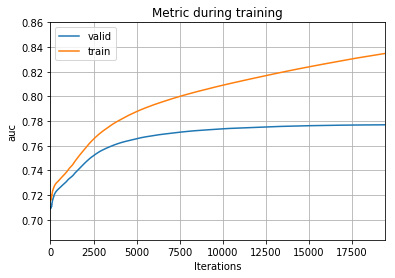

In [14]:
lightgbm.plot_metric(model)

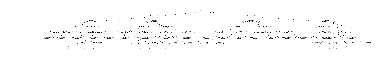

In [24]:
lightgbm.plot_tree(model)

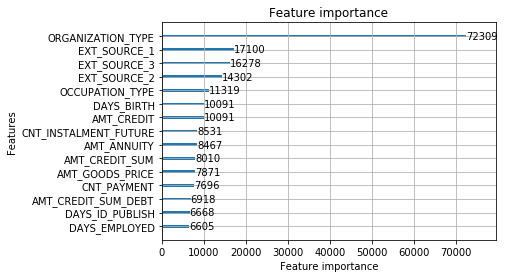

In [15]:
lightgbm.plot_importance(model, max_num_features=15)

### Submission

In [16]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
save_prediction(submission, 'lightgbm')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-lightgbm.csv -m "lightgbm"'